In [1]:
import anndata
import numpy
import scanpy
#import mudata
import tempfile
import os
import rpy2.robjects
import anndata2ri
from scipy.sparse import csr_matrix

anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_653736/2308273483.py:11: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
adata = anndata.read_h5ad("../SeuratObjects/2024-03-19-09-35anotated-alltsne-combined_seurat.h5ad")

In [7]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 41502 × 33502
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'unintegrated_clusters', 'seurat_clusters', 'rpca_clusters', 'harmony_clusters', 'mnn_clusters', 'cca_clusters', 'nCount_SCT', 'nFeature_SCT', 'sct_cca_clusters', 'sct_harmony_clusters', 'sct_harmony_2_clusters', 'sct_rcca_clusters', 'MouseRNA_SingleR.labels', 'Blueprint_SingleR.labels', 'ImmGen_SingleR.labels', 'ImmGen_fine_SingleR.labels', 'HPA_SingleR.labels', 'SCT_snn_harmony_Louvain_res.0.5', 'SCT_snn_harmony_Louvain_res.0.6', 'SCT_snn_harmony_Louvain_res.0.7', 'SCT_snn_harmony_Louvain_res.0.8', 'SCT_snn_harmony_Louvain_res.0.9', 'SCT_snn_harmony_Louvain_res.1', 'SCT_snn_harmony_Louvain_res.1.1', 'SCT_snn_harmony_Louvain_res.1.2', 'SCT_snn_harmony_Louvain_res.1.3', 'SCT_snn_harmony_Louvain_res.1.4', 'SCT_snn_harmony_Louvain_res.1.5', 'SCT_snn_harmony_Louvain_res.1.6', 'SCT_snn_harmony_Louvain_res.1.7', 'SCT_snn_harmony_Louvain_res.1.8', 'SCT_snn_harmony_Louvain_res.1.9'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


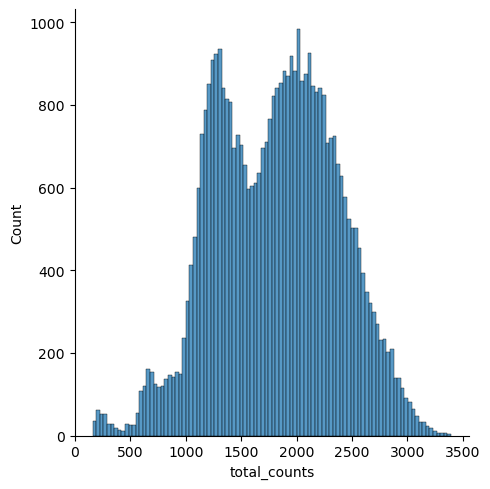

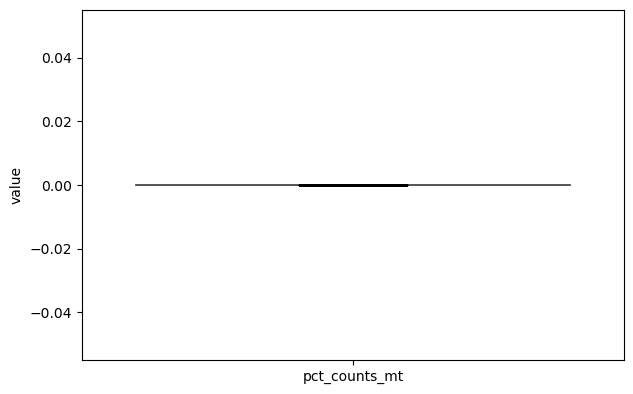

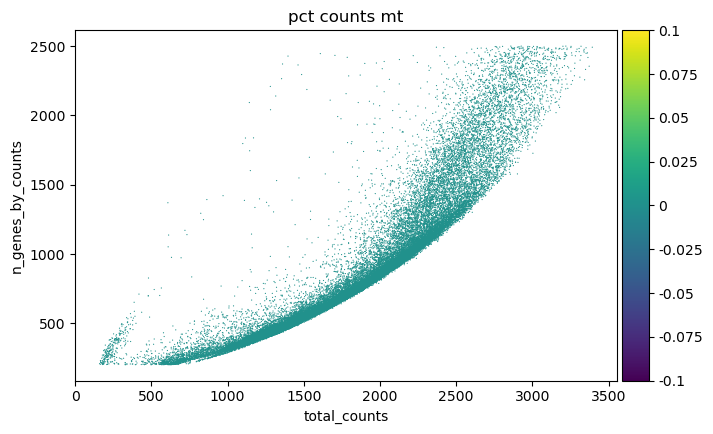

In [9]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [11]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    39581
True      1921
Name: outlier, dtype: int64

In [12]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    41502
Name: mt_outlier, dtype: int64

In [13]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 41502
Number of cells after filtering of low quality cells: 39581


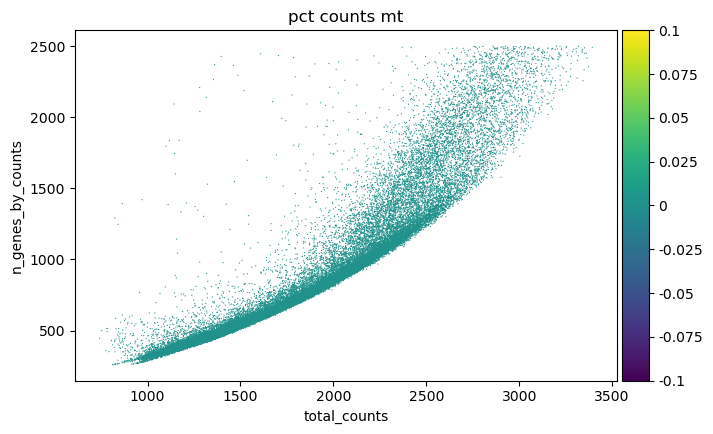

In [14]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [18]:
adata.write("../SeuratObjects/2024-03-19-10-45anotated-alltsne-combined_seurat-quality_control.h5ad")

In [2]:
adata = anndata.read_h5ad("../SeuratObjects/2024-03-19-10-45anotated-alltsne-combined_seurat-quality_control.h5ad")

In [3]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/tmp/ipykernel_653736/1527554728.py:22: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


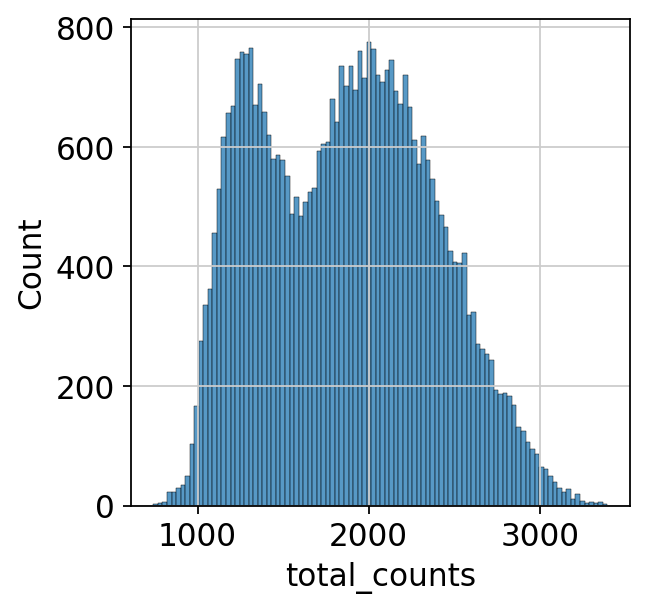

In [4]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [5]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

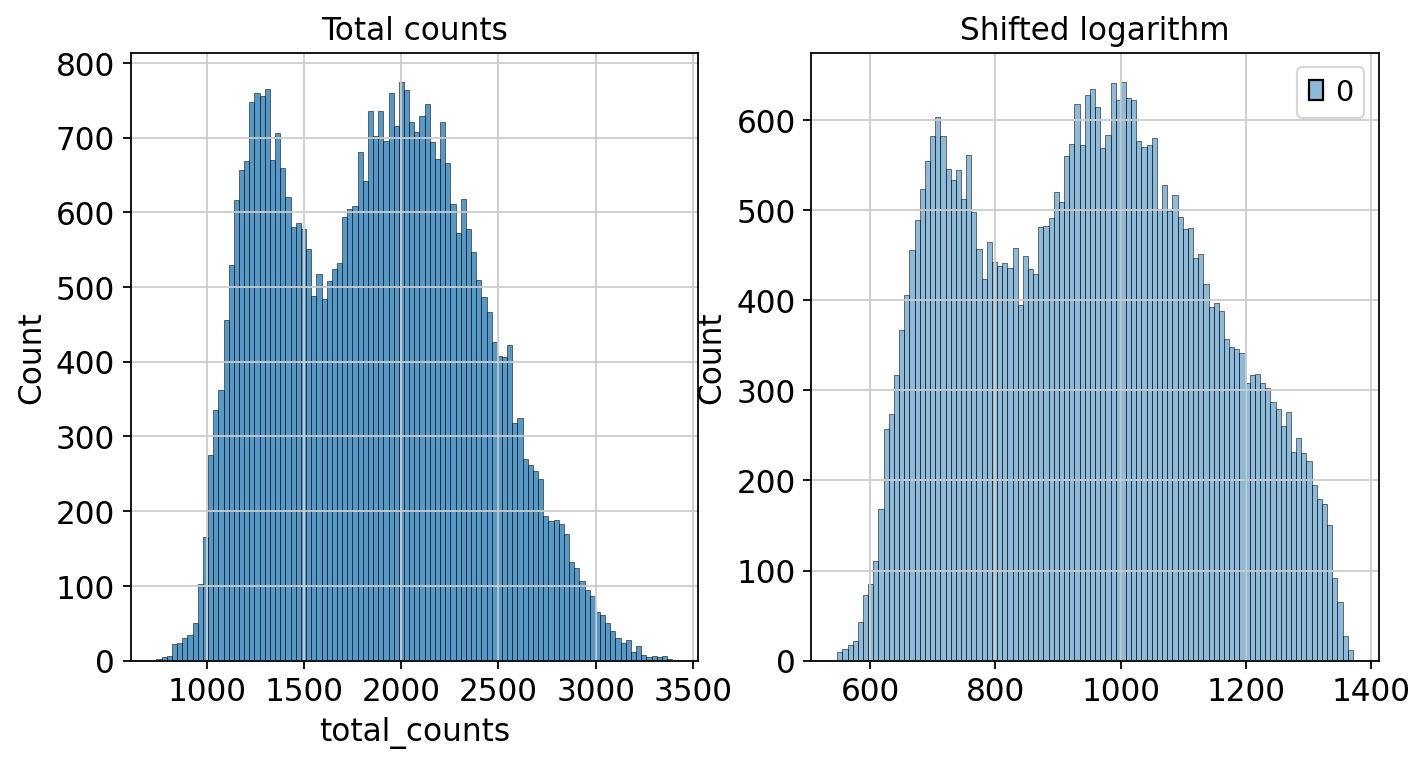

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()